<a href="https://colab.research.google.com/github/lucianozablocki/tiny_md/blob/main/cp_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv("https://raw.githubusercontent.com/lucianozablocki/tiny_md/refs/heads/main/results/atom.csv")

In [31]:
df

,particulas/s,N,opt,compiler,runs
0,326.816,4,-O0,gcc,20
1,328.226,4,-O0,gcc,20
2,327.769,4,-O0,gcc,20
3,322.085,4,-O0,gcc,20
4,322.785,4,-O0,gcc,20
...,...,...,...,...,...
515,40.491,256,-Ofast,clang,5
516,40.688,256,-Ofast,clang,5
517,40.657,256,-Ofast,clang,5
518,21.835,500,-Ofast,clang,2


In [ ]:
print(f"Length of original df: {len(df)}")
print("\nUnique values in each column:")
print(f"N values: {df['N'].unique()}")
print(f"opt flags: {df['opt'].unique()}")
print(f"compilers: {df['compiler'].unique()}")

Length of original df: 520

Unique values in each column:
N values: [  4  32 108 256 500]
opt flags: ['-O0' '-O1' '-O2' '-O3' '-Ofast']
compilers: ['gcc' 'clang']


In [ ]:
# Create a cross product of all possible combinations
compilers = ['gcc', 'clang']
opt_flags = ['-O0', '-O1', '-O2', '-O3', '-Ofast']
Ns = [4*m**3 for m in range(1,5+1)]  # [4, 32, 108, 256, 500]

# Create all possible combinations
all_combinations = pd.MultiIndex.from_product(
    [Ns, opt_flags, compilers],
    names=['N', 'opt', 'compiler']
).to_frame(index=False)

# Count measurements for each combination
counts = df.groupby(['N', 'opt', 'compiler']).size().reset_index(name='count')

# Merge to see which combinations have fewer than 5 measurements
analysis = all_combinations.merge(counts, how='left', on=['N', 'opt', 'compiler'])

# Print summary statistics
print("\nSummary:")
print(f"Total rows in df: {len(df)}")
print("\nMeasurement counts:")
print(analysis['count'].value_counts())


Summary:
Total rows in df: 520

Measurement counts:
count
20    10
15    10
10    10
5     10
2     10
Name: count, dtype: int64


In [ ]:
df_max = df.groupby(['N', 'opt', 'compiler'])['particulas/s'].max().reset_index()

In [ ]:
df_max

,N,opt,compiler,particulas/s
0,4,-O0,clang,238.357
1,4,-O0,gcc,212.023
2,4,-O1,clang,530.827
3,4,-O1,gcc,380.451
4,4,-O2,clang,536.327
5,4,-O2,gcc,412.782
6,4,-O3,clang,554.719
7,4,-O3,gcc,415.203
8,4,-Ofast,clang,424.787
9,4,-Ofast,gcc,564.370


In [ ]:
df=df_max

In [39]:
def plot_results_for(file_name, df):
  plt.figure(figsize=(15, 6))
  plt.title(file_name)

  # Plot for GCC
  plt.subplot(1, 2, 1)
  for opt in df['opt'].unique():
      data = df[(df['compiler'] == 'gcc') & (df['opt'] == opt)]
      plt.plot(data['N'], data['particulas/s'], 'o-', label=opt)

  plt.title('GCC Performance')
  plt.xlabel('N (number of particles)')
  plt.ylabel('Particles/s')
  plt.yscale('log')
  plt.legend()
  plt.grid(True)

  # Plot for Clang
  plt.subplot(1, 2, 2)
  for opt in df['opt'].unique():
      data = df[(df['compiler'] == 'clang') & (df['opt'] == opt)]
      plt.plot(data['N'], data['particulas/s'], 'o-', label=opt)

  plt.title('Clang Performance')
  plt.xlabel('N (number of particles)')
  plt.ylabel('Particles/s')
  plt.yscale('log')
  plt.legend()
  plt.grid(True)

  # Adjust layout to prevent overlap
  plt.tight_layout()

Processing file: atom
Processing file: jupiterace
Processing file: atom-native
Processing file: jupiterace-native
Processing file: atom-native-float


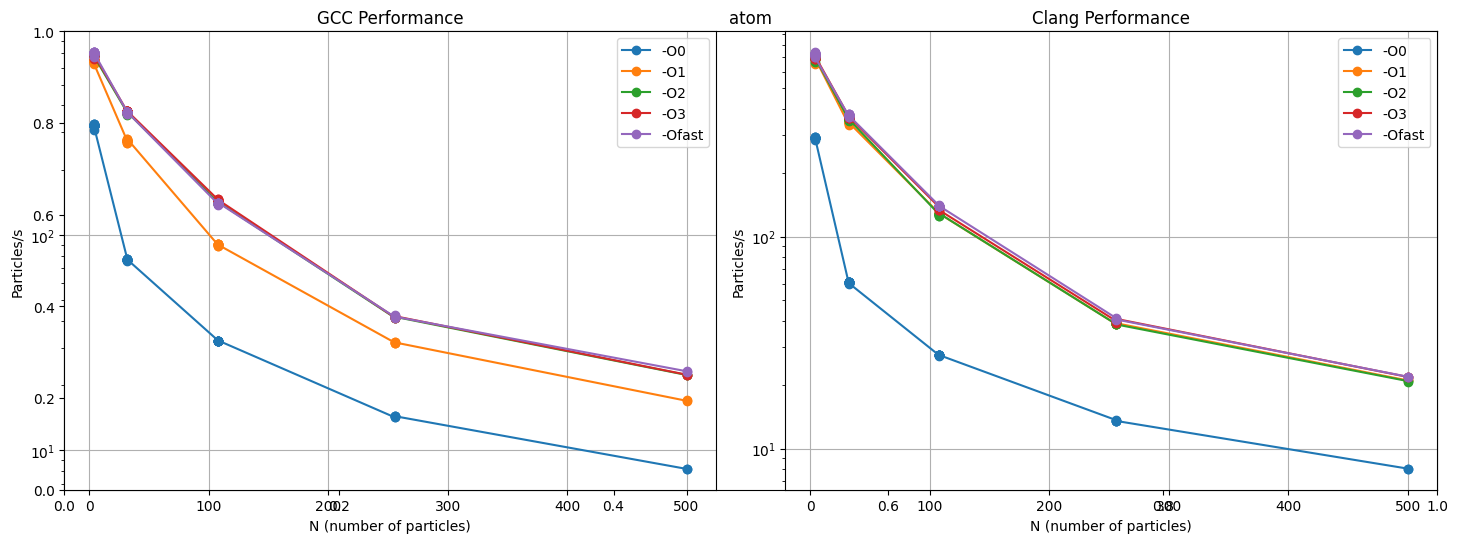

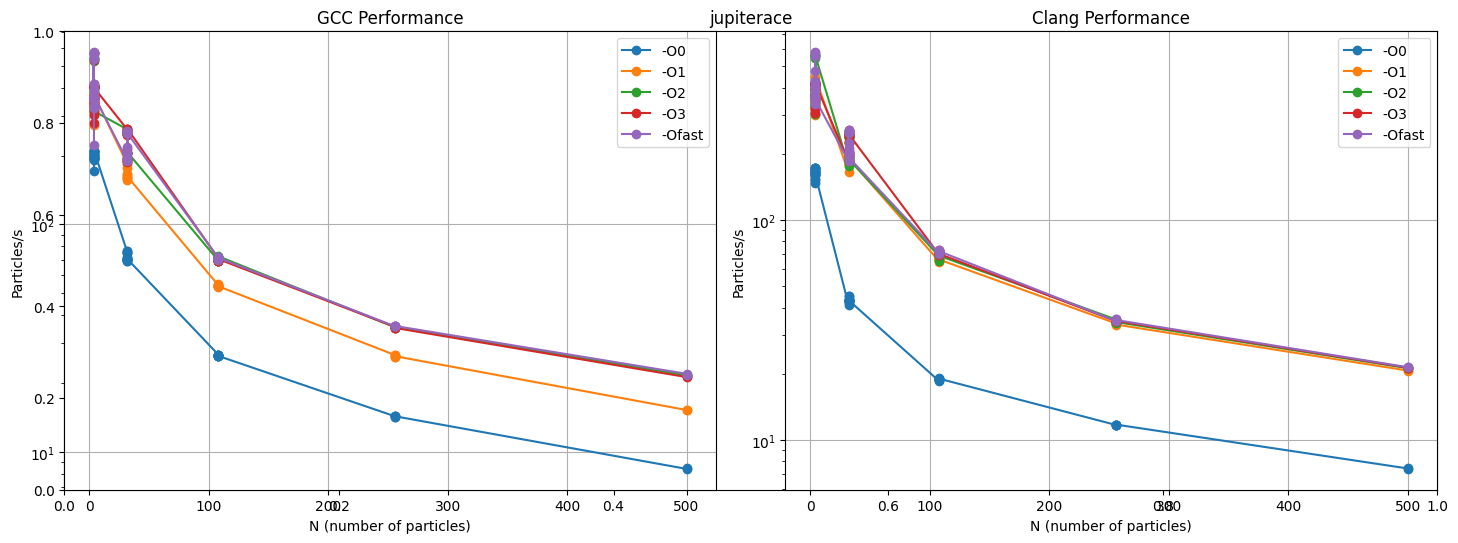

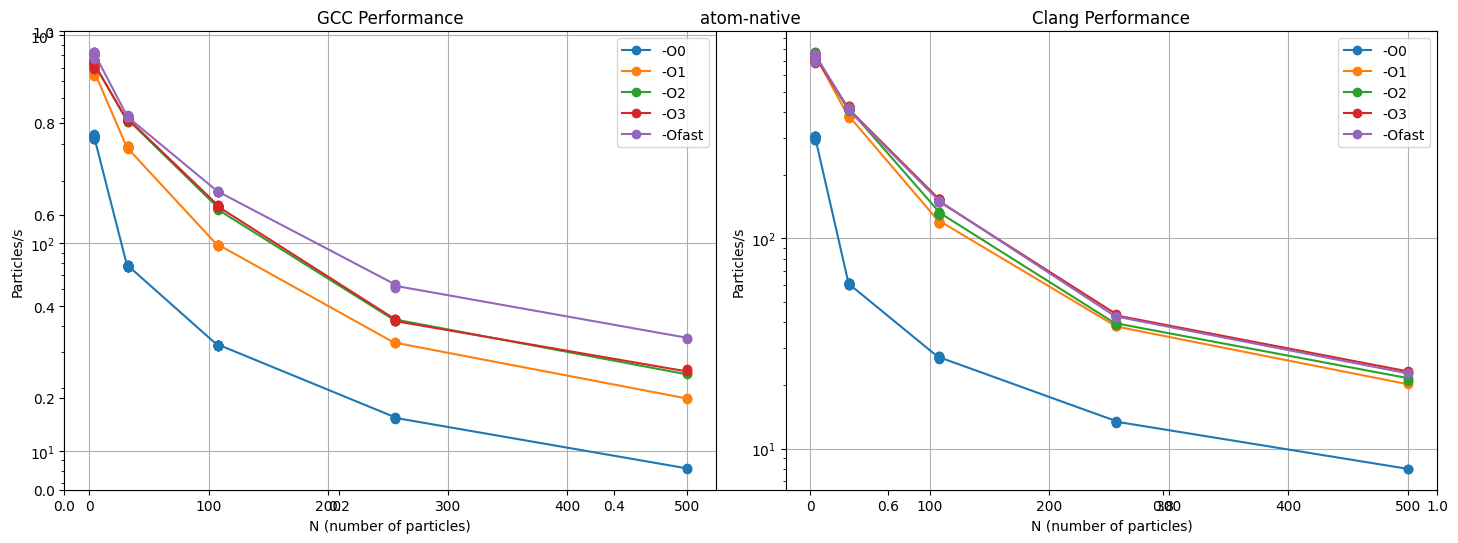

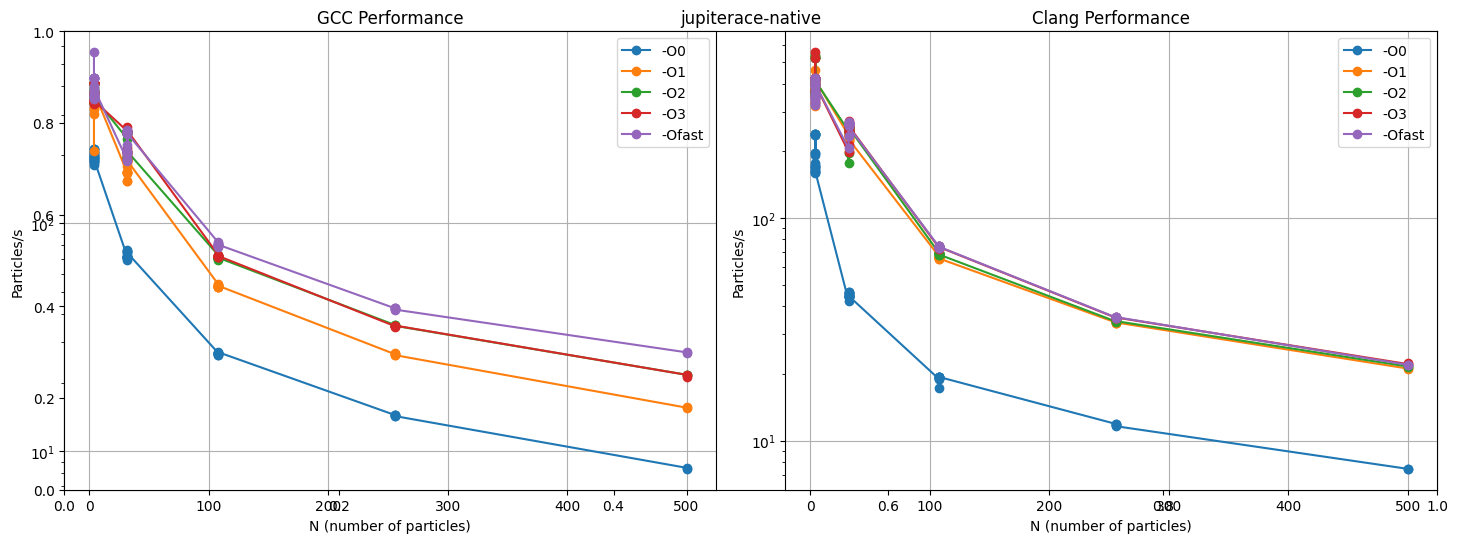

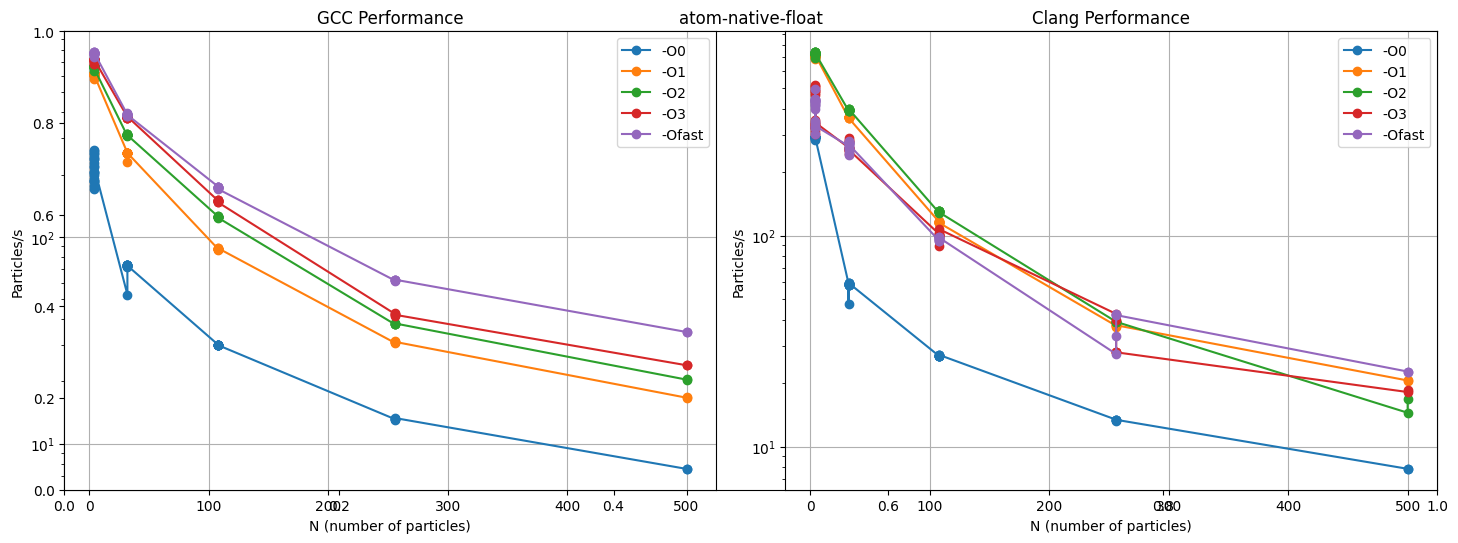

In [40]:
files = ['atom', 'jupiterace', 'atom-native', 'jupiterace-native', 'atom-native-float']
df = None
for file_name in files:
  print(f"Processing file: {file_name}")
  df = pd.read_csv(f"https://raw.githubusercontent.com/lucianozablocki/tiny_md/refs/heads/main/results/{file_name}.csv")
  plot_results_for(file_name, df)

In [ ]:
import pandas as pd

# Read the CSV file with tab separation
file_path = "/content/timeSGEMM-atom.txt"  # Replace with your file path
df = pd.read_csv(file_path, sep='\t', header=None, names=['size', 'time', 'MFLOPS'])

# Remove the 's' from time and ' MFLOPS' from MFLOPS and convert them to numeric
df['time'] = df['time'].str.replace(' s', '').astype(float)
df['MFLOPS'] = df['MFLOPS'].str.replace(' MFLOPS', '').astype(float)

# Group the data by 'size'
grouped = df.groupby('size')

# Calculate average time and MFLOPS for each size
avg_time = grouped['time'].mean()
avg_mflops = grouped['MFLOPS'].mean()

# Find the row with max MFLOPS for each size
max_mflops_row = grouped['MFLOPS'].idxmax()  # Find the index of the max MFLOPS per group
max_mflops_row = df.loc[max_mflops_row]  # Use the indices to get the corresponding rows

# Output the results
print("Average Time and MFLOPS per Size:")
print(f"Average Time:\n{avg_time}")
print(f"Average MFLOPS:\n{avg_mflops}")
print(f"Row with Max MFLOPS:\n{max_mflops_row}")

Average Time and MFLOPS per Size:
Average Time:
size
16384x16384x16384     4.343849
32768x32768x32768    31.902321
Name: time, dtype: float64
Average MFLOPS:
size
16384x16384x16384    2.027263e+06
32768x32768x32768    2.208652e+06
Name: MFLOPS, dtype: float64
Row with Max MFLOPS:
                 size       time        MFLOPS
8   16384x16384x16384   4.114502  2.137827e+06
19  32768x32768x32768  29.875342  2.355412e+06
